In [1]:
import numpy as np
import pandas as pd
import warnings
import os
from matplotlib import pyplot as plt

warnings.filterwarnings("ignore", message="The figure layout has changed to tight")

dfs = []

for filename in os.listdir('datasets/debian'):
    if filename.endswith('.csv'):
        filepath = os.path.join('datasets/debian', filename)
        
        # Read the CSV file skipping the first row
        df = pd.read_csv(filepath)

        # Remove first row
        df = df.iloc[1:]
        df['source'] = 'PNode1'
        
        for column in df.filter(like='_avg_watts_consumption').columns:
            prefix = column.split('_avg_watts_consumption')[0]

            duration = df[f'{prefix}_duration']
            watts = df[column]

            df[f'{prefix}_joules_consumption'] = (watts - 13.2) * duration
        
        # Append the DataFrame to the list
        dfs.append(df)

for filename in os.listdir('datasets/lamport'):
    if filename.endswith('.csv'):
        filepath = os.path.join('datasets/lamport', filename)
        
        # Read the CSV file skipping the first row
        df = pd.read_csv(filepath)

        # Remove first row
        df = df.iloc[1:]
        df['source'] = 'PNode2'

        for column in df.filter(like='_avg_watts_consumption').columns:
            prefix = column.split('_avg_watts_consumption')[0]

            duration = df[f'{prefix}_duration']
            watts = df[column]

            df[f'{prefix}_joules_consumption'] = (watts - 19.5) * duration
        
        # Append the DataFrame to the list
        dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
df.sort_values(by=['source', 'pipeline_id'], inplace=True)
df

,project_id,concurrency_degree,pipeline_id,pipeline_start,pipeline_finish,pipeline_duration,pipeline_avg_watts_consumption,pipeline_avg_ram_consumption,pipeline_avg_disk_consumption,pipeline_avg_cpu_usage,...,job13,job13_id,job13_start,job13_finish,job13_duration,source,pipeline_joules_consumption,stage1_joules_consumption,stage2_joules_consumption,stage3_joules_consumption
0,21,1,1955,1716319455,1716320276,821,33.115989,12449.068146,375674.056704,12.703395,...,deploy_nightly,25120,1716320247,1716320276,29,PNode1,16351.026919,5791.024413,8660.378090,1753.062912
1,21,1,1956,1716320896,1716321723,827,32.837155,12552.172265,375517.256462,12.337121,...,deploy_nightly,25133,1716321694,1716321723,29,PNode1,16239.927457,5940.549926,8534.415192,1722.844779
2,21,1,1957,1716322338,1716323157,819,33.285158,12649.317035,375741.536787,13.009877,...,deploy_nightly,25146,1716323128,1716323157,29,PNode1,16449.744192,5915.770463,8696.793305,1789.936250
3,21,1,1958,1716323779,1716324599,820,32.862797,12622.394254,375594.914171,12.874074,...,deploy_nightly,25159,1716324571,1716324599,28,PNode1,16123.493388,5698.695630,8646.725965,1756.203919
4,21,1,1959,1716325222,1716326039,817,32.869067,12626.285682,375430.432085,12.310802,...,deploy_nightly,25172,1716326011,1716326039,28,PNode1,16069.627366,6014.853310,8269.414293,1761.802499
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,8,6,3121,1717279861,1717280380,519,69.539848,22323.541655,337482.299874,28.770698,...,deploy_nightly,30958,1717280279,1717280328,49,PNode2,25970.680982,9309.832992,13284.459137,3248.192101
596,8,6,3122,1717280403,1717280922,519,69.362594,22348.620017,335425.494438,28.560215,...,deploy_nightly,30971,1717280821,1717280870,49,PNode2,25878.686106,9160.629232,13209.230289,3267.787199
597,8,6,3123,1717280947,1717281473,526,69.560787,22349.804690,335359.142415,27.964372,...,deploy_nightly,30984,1717281369,1717281418,49,PNode2,26331.974083,9876.361022,13236.468979,3271.507387
598,8,6,3124,1717281487,1717282015,528,68.613024,22310.173901,337839.329631,28.241998,...,deploy_nightly,30997,1717281911,1717281959,48,PNode2,25931.676433,9574.613846,13235.378953,3247.234190


In [2]:
node1 = df[df['source'] == 'PNode1']
node2 = df[df['source'] == 'PNode2']

In [3]:
import seaborn as sns

colors = sns.color_palette('deep', 6)

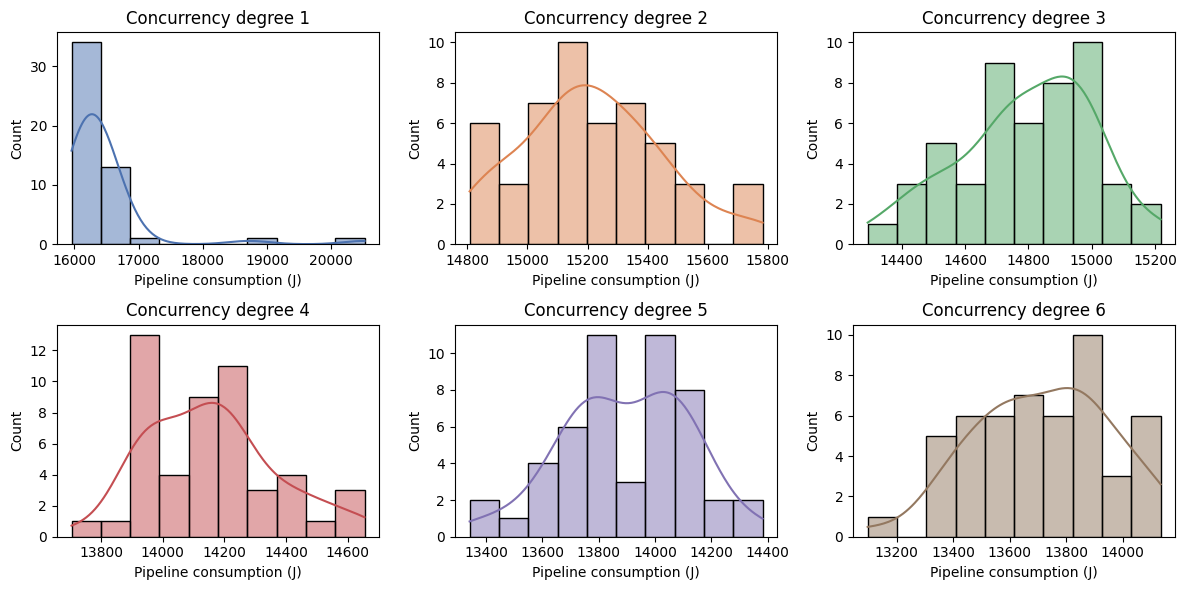

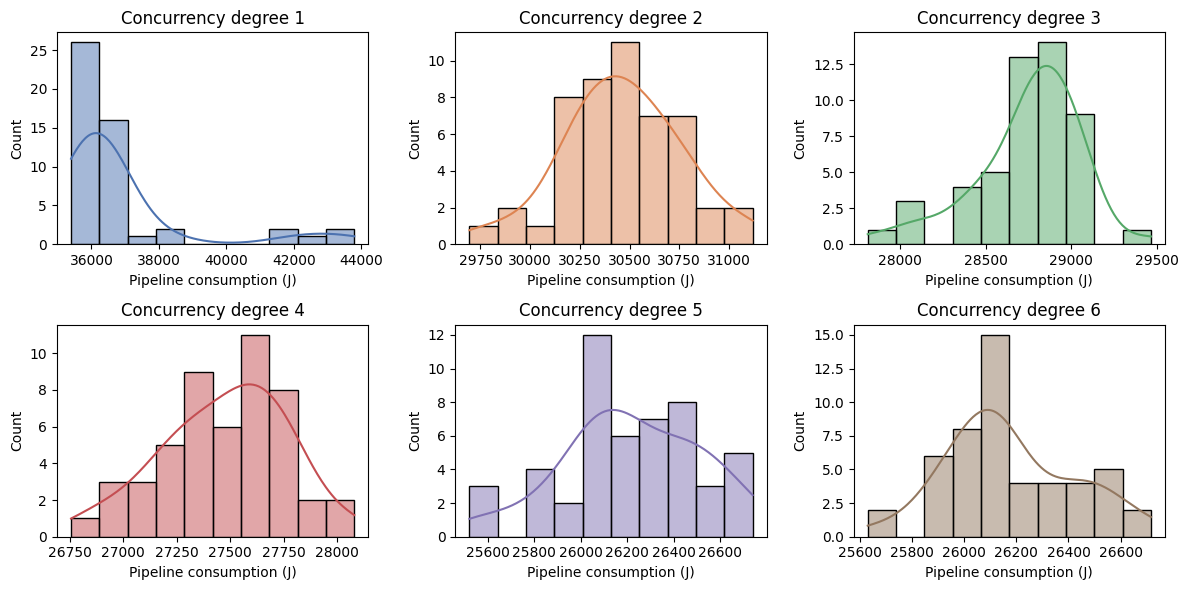

In [4]:
for node, df in enumerate([node1, node2]):
    fig, axes = plt.subplots(2, 3, figsize=(12, 6))
    axes = axes.flatten()

    for i in range(1, 7):
        ax = axes[i - 1]
        sns.histplot(df[df['concurrency_degree'] == i]['pipeline_joules_consumption'],
                 ax=ax, 
                 color=colors[i - 1],
                 kde=True,
                 bins=10)
        ax.set_title(f'Concurrency degree {i}')
        ax.set_xlabel('Pipeline consumption (J)')

    plt.tight_layout()
    plt.savefig(f'pnode-{node+1}-hist-with-outliers.pdf', dpi=300)
    plt.show()

IQR

In [5]:
from matplotlib.cbook import boxplot_stats

def get_iqr_range(df, concurrency_degree):
    stats = boxplot_stats(df[df['concurrency_degree'] ==
                          concurrency_degree]['pipeline_joules_consumption'])

    Q1 = stats[0]['q1']
    Q3 = stats[0]['q3']
        
    IQR = Q3 - Q1
    max = Q3 + 1.5 * IQR
    min = Q1 - 1.5 * IQR

    return min, max

Remove outliers

In [6]:
for node in [node1, node2]:
    for i in range(1, 7):
        min, max = get_iqr_range(node, i)

        rm = node[node['concurrency_degree'] == i][(node[node['concurrency_degree'] == i]['pipeline_joules_consumption'] < min) | (
            node[node['concurrency_degree'] == i]['pipeline_joules_consumption'] > max)]

        node.drop(rm.index, inplace=True)

/var/folders/tc/_vy_hkrd0437j7j655yvr_z40000gn/T/ipykernel_42127/296047968.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  node.drop(rm.index, inplace=True)


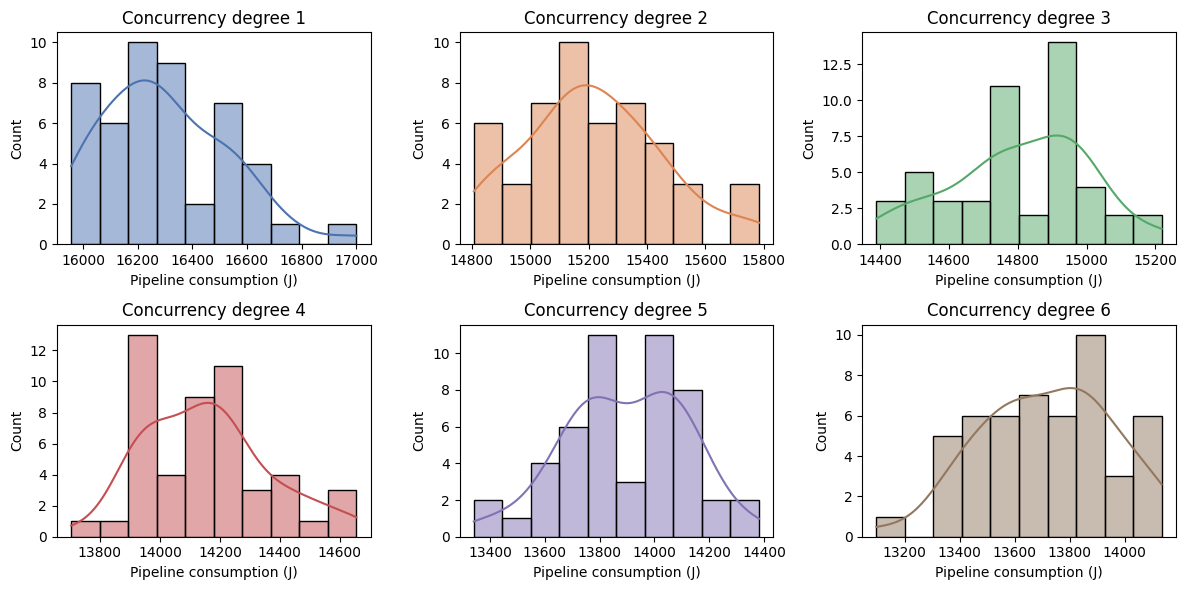

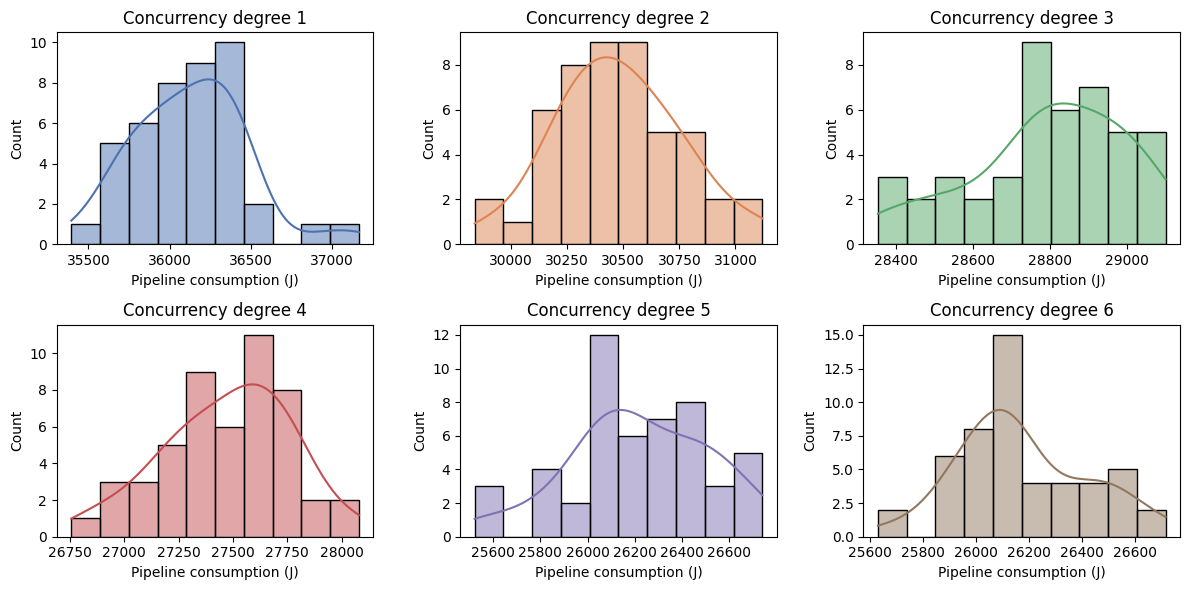

In [7]:
for node, df in enumerate([node1, node2]):
    fig, axes = plt.subplots(2, 3, figsize=(12, 6))
    axes = axes.flatten()

    for i in range(1, 7):
        ax = axes[i - 1]
        sns.histplot(df[df['concurrency_degree'] == i]['pipeline_joules_consumption'],
                     ax=ax,
                     color=colors[i - 1],
                     kde=True,
                     bins=10)
        ax.set_title(f'Concurrency degree {i}')
        ax.set_xlabel('Pipeline consumption (J)')

    plt.tight_layout()
    plt.savefig(f'pnode-{node+1}-hist-without-outliers.pdf', dpi=300)
    plt.show()

In [8]:
node12 = pd.concat([node1, node2])

Normality test

In [9]:
from scipy.stats import shapiro

normal = []
non_normal = []

for node, df in node12.groupby('source'):
    for i in range(1, 7):
        stat, p = shapiro(df[df['concurrency_degree'] == i]
                          ['pipeline_joules_consumption'])
        alpha = 0.05
        if p > alpha:
            print(node, f"Concurrency Degree {i},", "Normal,", f"Stat={stat}, p-value={p}")
            normal.append((node, i))
        else:
            print(node, f"Concurrency Degree {i},",
                  "Non-normal,", f"Stat={stat}, p-value={p}")
            non_normal.append((node, i))
    print()

PNode1 Concurrency Degree 1, Normal, Stat=0.9563915729522705, p-value=0.07216433435678482
PNode1 Concurrency Degree 2, Normal, Stat=0.9764867424964905, p-value=0.41507720947265625
PNode1 Concurrency Degree 3, Normal, Stat=0.9666187763214111, p-value=0.17700424790382385
PNode1 Concurrency Degree 4, Normal, Stat=0.9634223580360413, p-value=0.12366563826799393
PNode1 Concurrency Degree 5, Normal, Stat=0.9832330346107483, p-value=0.6938013434410095
PNode1 Concurrency Degree 6, Normal, Stat=0.9790257811546326, p-value=0.5116449594497681

PNode2 Concurrency Degree 1, Normal, Stat=0.9664445519447327, p-value=0.23727183043956757
PNode2 Concurrency Degree 2, Normal, Stat=0.992257833480835, p-value=0.9855879545211792
PNode2 Concurrency Degree 3, Non-normal, Stat=0.9468690752983093, p-value=0.03870394080877304
PNode2 Concurrency Degree 4, Normal, Stat=0.9837606549263, p-value=0.7173001170158386
PNode2 Concurrency Degree 5, Normal, Stat=0.9760397672653198, p-value=0.3994906544685364
PNode2 Concurr

In [10]:
node12_by_concurrency_degree = pd.DataFrame(columns=['source', 'concurrency_degree','pipeline_joules_consumption', 'pipeline_duration', 'pipeline_avg_cpu_usage', 'pipeline_max_cpu_usage', 'pipeline_avg_ram_consumption', 'pipeline_avg_disk_consumption'])

for node, df in node12.groupby('source'):
    for i in range(1,7):
        group = df[(df['source'] == node) & (df['concurrency_degree'] == i)]
        node12_by_concurrency_degree.loc[len(node12_by_concurrency_degree.index)] = [
            node, 
            i, 
            group['pipeline_joules_consumption'].mean() if (node, i) in normal else group['pipeline_joules_consumption'].median(),
            group['pipeline_duration'].mean(), 
            group['pipeline_avg_cpu_usage'].mean(),  
            group['pipeline_max_cpu_usage'].mean(), 
            group['pipeline_avg_ram_consumption'].mean(),  
            group['pipeline_avg_disk_consumption'].mean()
        ]

node12_by_concurrency_degree

,source,concurrency_degree,pipeline_joules_consumption,pipeline_duration,pipeline_avg_cpu_usage,pipeline_max_cpu_usage,pipeline_avg_ram_consumption,pipeline_avg_disk_consumption
0,PNode1,1,16299.720217,820.166667,12.334396,34.890972,12712.242976,375381.457046
1,PNode1,2,15217.228696,554.780000,18.800759,50.259833,13041.518268,376358.916188
2,PNode1,3,14806.774925,478.265306,22.845818,59.656803,13183.763958,375390.172654
3,PNode1,4,14154.213759,434.240000,26.167843,74.428667,13325.233542,375897.571695
4,PNode1,5,13896.598793,375.240000,32.738940,84.934802,13664.110025,376923.837799
5,PNode1,6,13715.400933,371.020000,33.184571,84.225117,13713.266288,376724.631629
6,PNode2,1,36127.339268,1242.767442,11.337139,43.140337,21089.842340,336320.608324
7,PNode2,2,30477.023629,827.448980,16.959506,52.453653,21112.484323,336676.161786
8,PNode2,3,28806.403686,700.822222,19.955841,61.818025,21357.899003,336116.800092
9,PNode2,4,27473.162084,634.620000,22.532977,73.883238,21434.616523,336368.343859


In [11]:
from matplotlib.ticker import FuncFormatter

def format_joules(x, pos):
    if x >= 1000000:
        return '{:.0f} MJ'.format(x / 1000000)
    elif x >= 1000:
        return '{:.0f} kJ'.format(x / 1000)
    else:
        return '{:.0f} J'.format(x)


def seconds_to_minutes(x, pos):
    return '{:.0f} m'.format(x / 60)

def mb_to_gb(x, pos):
    return '{:.0f} GB'.format(x / 1024)

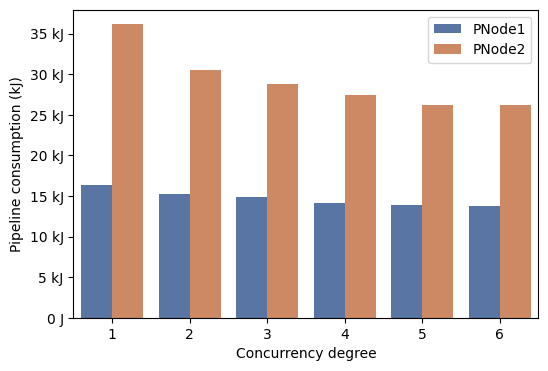

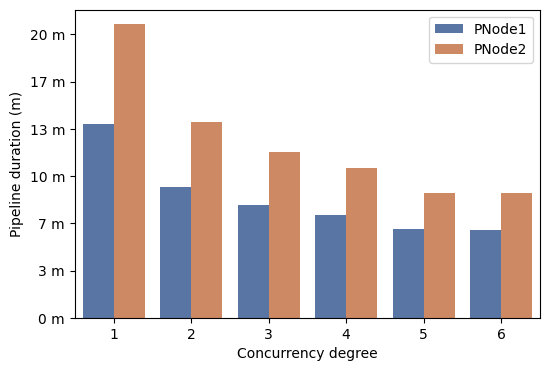

In [12]:
plt.figure(figsize=(6, 4))
sns.barplot(data=node12_by_concurrency_degree, x='concurrency_degree', y='pipeline_joules_consumption', hue='source', palette='deep')

plt.xlabel('Concurrency degree')
plt.ylabel('Pipeline consumption (kJ)')

plt.legend(title='')

plt.gca().yaxis.set_major_formatter(FuncFormatter(format_joules))

plt.legend(title='')
plt.savefig('consumption.pdf', dpi=300)
plt.show()

plt.figure(figsize=(6, 4))
sns.barplot(data=node12_by_concurrency_degree, x='concurrency_degree', y='pipeline_duration', hue='source', palette='deep')

plt.xlabel('Concurrency degree')
plt.ylabel('Pipeline duration (m)')

plt.gca().yaxis.set_major_formatter(FuncFormatter(seconds_to_minutes))

plt.legend(title='')
plt.savefig('duration.pdf', dpi=300)
plt.show()

Descriptive stats: energy consumption

In [13]:
for (source, concurrency_degree), i in node12.groupby(['source', 'concurrency_degree'])['pipeline_joules_consumption']:
      if (source, concurrency_degree) in normal:
            print(f"Concurrency={concurrency_degree}; Source={source}", "Mean", round(i.mean(), 2))
      else:
            print(f"Concurrency={concurrency_degree}; Source={source}", "Median", round(i.median(), 2))
      print(f"Concurrency={concurrency_degree}; Source={source}", "Std", round(i.std(), 2))
      print(f"Concurrency={concurrency_degree}; Source={source}",
            "0.25 Quartile", round(i.quantile(0.25), 2))
      print(f"Concurrency={concurrency_degree}; Source={source}",
            "0.50 Quartile", round(i.quantile(0.50), 2))
      print(f"Concurrency={concurrency_degree}; Source={source}",
            "0.75 Quartile", round(i.quantile(0.75), 2))

Concurrency=1; Source=PNode1 Mean 16299.72
Concurrency=1; Source=PNode1 Std 230.33
Concurrency=1; Source=PNode1 0.25 Quartile 16146.34
Concurrency=1; Source=PNode1 0.50 Quartile 16269.47
Concurrency=1; Source=PNode1 0.75 Quartile 16487.72
Concurrency=2; Source=PNode1 Mean 15217.23
Concurrency=2; Source=PNode1 Std 235.73
Concurrency=2; Source=PNode1 0.25 Quartile 15081.29
Concurrency=2; Source=PNode1 0.50 Quartile 15187.9
Concurrency=2; Source=PNode1 0.75 Quartile 15364.25
Concurrency=3; Source=PNode1 Mean 14806.77
Concurrency=3; Source=PNode1 Std 200.34
Concurrency=3; Source=PNode1 0.25 Quartile 14718.94
Concurrency=3; Source=PNode1 0.50 Quartile 14802.13
Concurrency=3; Source=PNode1 0.75 Quartile 14950.8
Concurrency=4; Source=PNode1 Mean 14154.21
Concurrency=4; Source=PNode1 Std 207.3
Concurrency=4; Source=PNode1 0.25 Quartile 13974.37
Concurrency=4; Source=PNode1 0.50 Quartile 14162.37
Concurrency=4; Source=PNode1 0.75 Quartile 14254.45
Concurrency=5; Source=PNode1 Mean 13896.6
Concu

Descriptive stats: duration

In [14]:
for (source, concurrency_degree), i in node12.groupby(['source', 'concurrency_degree'])['pipeline_duration']:
    print(f"Concurrency={concurrency_degree}; Source={source}", "Mean", round(i.mean(), 2))
    print(f"Concurrency={concurrency_degree}; Source={source}", "Std", round(i.std(), 2))
    print(f"Concurrency={concurrency_degree}; Source={source}",
        "0.25 Quartile", round(i.quantile(0.25), 2))
    print(f"Concurrency={concurrency_degree}; Source={source}",
        "0.50 Quartile", round(i.quantile(0.50), 2))
    print(f"Concurrency={concurrency_degree}; Source={source}",
        "0.75 Quartile", round(i.quantile(0.75), 2))

Concurrency=1; Source=PNode1 Mean 820.17
Concurrency=1; Source=PNode1 Std 5.51
Concurrency=1; Source=PNode1 0.25 Quartile 817.0
Concurrency=1; Source=PNode1 0.50 Quartile 819.5
Concurrency=1; Source=PNode1 0.75 Quartile 822.25
Concurrency=2; Source=PNode1 Mean 554.78
Concurrency=2; Source=PNode1 Std 31.87
Concurrency=2; Source=PNode1 0.25 Quartile 543.0
Concurrency=2; Source=PNode1 0.50 Quartile 547.0
Concurrency=2; Source=PNode1 0.75 Quartile 553.0
Concurrency=3; Source=PNode1 Mean 478.27
Concurrency=3; Source=PNode1 Std 4.96
Concurrency=3; Source=PNode1 0.25 Quartile 476.0
Concurrency=3; Source=PNode1 0.50 Quartile 479.0
Concurrency=3; Source=PNode1 0.75 Quartile 480.0
Concurrency=4; Source=PNode1 Mean 434.24
Concurrency=4; Source=PNode1 Std 4.93
Concurrency=4; Source=PNode1 0.25 Quartile 431.0
Concurrency=4; Source=PNode1 0.50 Quartile 434.5
Concurrency=4; Source=PNode1 0.75 Quartile 437.0
Concurrency=5; Source=PNode1 Mean 375.24
Concurrency=5; Source=PNode1 Std 3.68
Concurrency=5; 

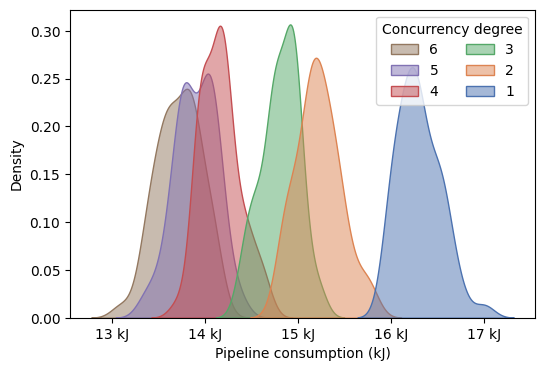

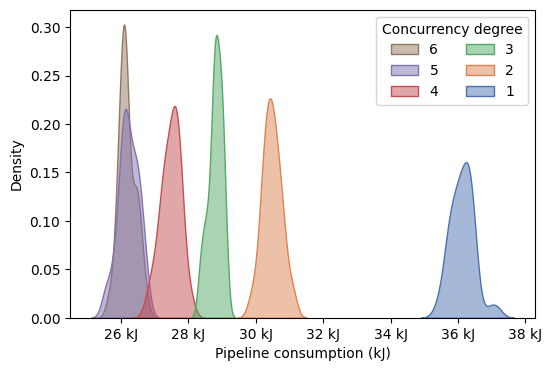

In [15]:
plt.figure(figsize=(6, 4))
sns.kdeplot(data=node1, x=node1['pipeline_joules_consumption'] / 1000,
            hue='concurrency_degree', palette='deep', fill=True, alpha=.5)
plt.xlabel('Pipeline consumption (kJ)')
plt.ylabel('Density')
plt.legend(title='Concurrency degree', labels=[6, 5, 4, 3, 2, 1], ncol=2)
plt.gca().xaxis.set_major_formatter('{x:1.0f} kJ')

plt.savefig('pnode-1-kde-plot-consumption.pdf', dpi=300)
plt.show()

plt.figure(figsize=(6, 4))
sns.kdeplot(data=node2, x=node2['pipeline_joules_consumption'] / 1000,
            hue='concurrency_degree', palette='deep', fill=True, alpha=.5)
plt.xlabel('Pipeline consumption (kJ)')
plt.ylabel('Density')
plt.legend(title='Concurrency degree', labels=[6, 5, 4, 3, 2, 1], ncol=2)
plt.gca().xaxis.set_major_formatter('{x:1.0f} kJ')

plt.savefig('pnode-2-kde-plot-consumption.pdf', dpi=300)
plt.show()

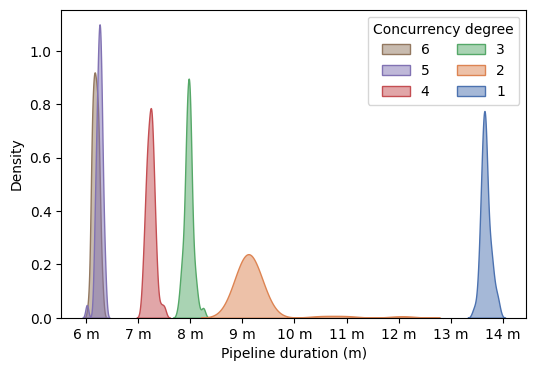

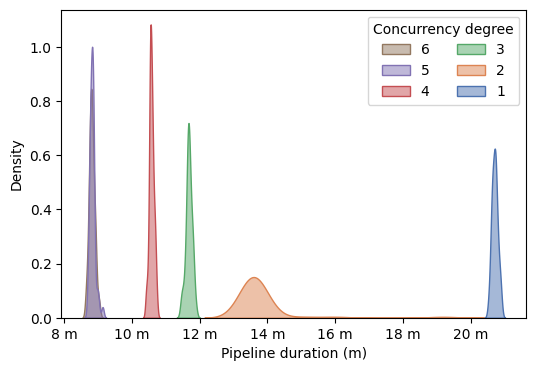

In [16]:
plt.figure(figsize=(6, 4))
sns.kdeplot(data=node1, x=node1['pipeline_duration'] / 60,
            hue='concurrency_degree', palette='deep', fill=True, alpha=.5)
plt.xlabel('Pipeline duration (m)')
plt.ylabel('Density')
plt.legend(title='Concurrency degree', labels=[6, 5, 4, 3, 2, 1], ncol=2)
plt.gca().xaxis.set_major_formatter('{x:1.0f} m')

plt.savefig('pnode-1-kde-plot-duration.pdf', dpi=300)
plt.show()

plt.figure(figsize=(6, 4))
sns.kdeplot(data=node2, x=node2['pipeline_duration'] / 60,
            hue='concurrency_degree', palette='deep', fill=True, alpha=.5)
plt.xlabel('Pipeline duration (m)')
plt.ylabel('Density')
plt.legend(title='Concurrency degree', labels=[6, 5, 4, 3, 2, 1], ncol=2)
plt.gca().xaxis.set_major_formatter('{x:1.0f} m')

plt.savefig('pnode-2-kde-plot-duration.pdf', dpi=300)
plt.show()

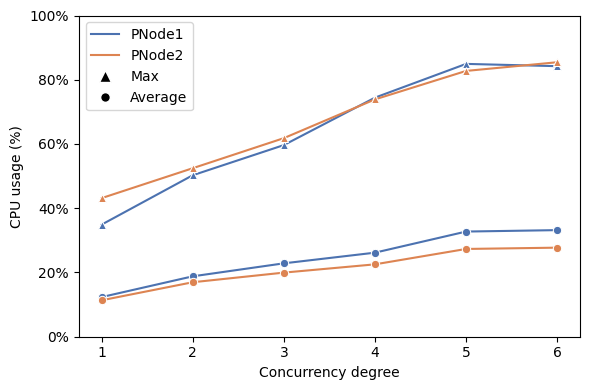

In [17]:
import matplotlib.ticker as mtick
plt.figure(figsize=(6, 4))

sns.lineplot(x='concurrency_degree', y='pipeline_avg_cpu_usage', data=node12_by_concurrency_degree, marker='o', hue='source', palette='deep', legend='full')

sns.lineplot(x='concurrency_degree', y='pipeline_max_cpu_usage', data=node12_by_concurrency_degree, marker='^', hue='source', palette='deep', legend=False)

plt.xlabel('Concurrency degree')
plt.ylabel('CPU usage (%)')
plt.ylim(0, 100)

handles, labels = plt.gca().get_legend_handles_labels()
handles.extend([plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='k', markersize=8, label='Max'), plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markersize=7, label='Average')])
labels.extend(['Max', 'Average'])
plt.legend(handles, labels, title='')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.tight_layout()

plt.savefig('avg-max-cpu-usage.pdf', dpi=300)
plt.show()

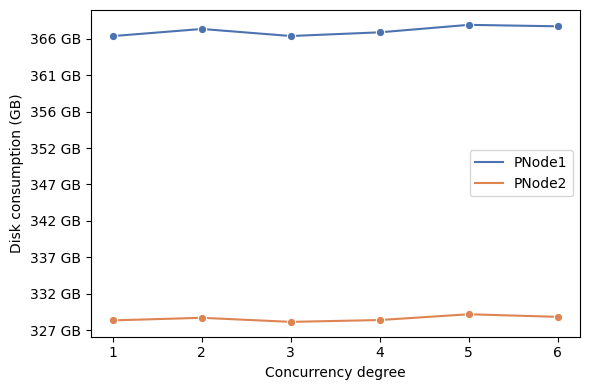

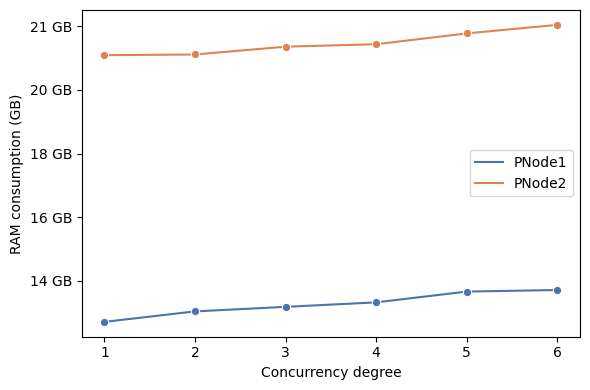

In [18]:
plt.figure(figsize=(6, 4))
sns.lineplot(x='concurrency_degree', y='pipeline_avg_disk_consumption',
             data=node12_by_concurrency_degree, marker='o', hue='source', palette='deep', legend='full')

plt.xlabel('Concurrency degree')
plt.ylabel('Disk consumption (GB)')

plt.legend(title='')
plt.gca().yaxis.set_major_formatter(FuncFormatter(mb_to_gb))
plt.tight_layout()

plt.savefig('avg-disk-consumption.pdf', dpi=300)
plt.show()

plt.figure(figsize=(6, 4))
sns.lineplot(x='concurrency_degree', y='pipeline_avg_ram_consumption',
             data=node12_by_concurrency_degree, marker='o', hue='source', palette='deep', legend='full')

plt.xlabel('Concurrency degree')
plt.ylabel('RAM consumption (GB)')

plt.legend(title='')
plt.gca().yaxis.set_major_formatter(FuncFormatter(mb_to_gb))
plt.tight_layout()

plt.savefig('avg-ram-consumption.pdf', dpi=300)
plt.show()

Load EU avg kWh prices per year

In [19]:
kwh_price_per_year = pd.read_table('nrg_pc_205_page_tabular.tsv')
del kwh_price_per_year[kwh_price_per_year.columns[0]]

kwh_price_per_year

,2019-S1,2019-S2,2020-S1,2020-S2,2021-S1,2021-S2,2022-S1,2022-S2,2023-S1,2023-S2
0,0.0842,0.0779,0.0817,0.0819,0.0859,0.1031,0.1604,0.1986,0.1936,0.1771


/var/folders/tc/_vy_hkrd0437j7j655yvr_z40000gn/T/ipykernel_42127/2145739754.py:16: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=time_periods.flatten(), y=values,
/var/folders/tc/_vy_hkrd0437j7j655yvr_z40000gn/T/ipykernel_42127/2145739754.py:18: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=time_periods.flatten(), y=predictions,


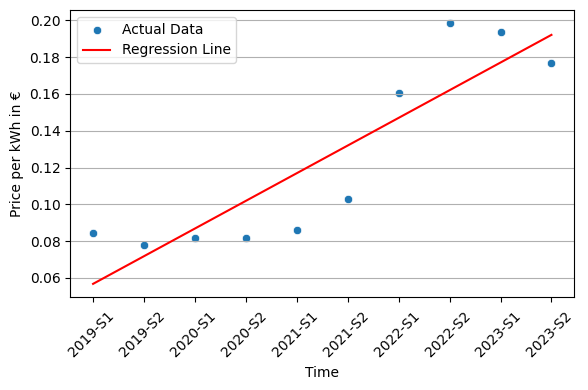

(0.015049696969696966, 0.041666666666666685)

In [20]:
from sklearn.linear_model import LinearRegression

time_periods = np.array(
    range(1, len(kwh_price_per_year.columns) + 1)).reshape(-1, 1)
values = kwh_price_per_year.values.flatten()

model = LinearRegression()
model.fit(time_periods, values)

predictions = model.predict(time_periods)

slope = model.coef_[0]
intercept = model.intercept_

plt.figure(figsize=(6, 4))
sns.scatterplot(x=time_periods.flatten(), y=values,
                palette='deep', label='Actual Data')
sns.lineplot(x=time_periods.flatten(), y=predictions,
             palette='deep', color='red', label='Regression Line')
plt.xlabel('Time')
plt.ylabel('Price per kWh in €')
plt.gca().yaxis.grid(True)
plt.xticks(time_periods.flatten(), kwh_price_per_year.columns, rotation=45)
plt.legend()
plt.tight_layout()

plt.savefig('energy-cost-regression.pdf', dpi=300)
plt.show()

slope, intercept

Calculate pipeline kWh cost when run 10x a day, 5x a week, 52x weeks a year

In [21]:
node1['pipeline_kwh_cost_per_year'] = (
    node1['pipeline_joules_consumption'] * 10 * 5 * 52) / 3600000
node2['pipeline_kwh_cost_per_year'] = (
    node2['pipeline_joules_consumption'] * 10 * 5 * 52) / 3600000

/var/folders/tc/_vy_hkrd0437j7j655yvr_z40000gn/T/ipykernel_42127/4139782933.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  node1['pipeline_kwh_cost_per_year'] = (
/var/folders/tc/_vy_hkrd0437j7j655yvr_z40000gn/T/ipykernel_42127/4139782933.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  node2['pipeline_kwh_cost_per_year'] = (


In [22]:
def calculate_energy_cost(years, current_cost_per_kWh, annual_increase_rate, annual_energy_consumption):
    # Initialize variables
    total_cost = 0
    current_cost = current_cost_per_kWh

    data = []

    # Loop through each year
    for year in range(1, years + 1):
        # Calculate energy cost for the current year
        cost_for_year = current_cost * annual_energy_consumption

        # Add current year's cost to the total
        total_cost += cost_for_year
        data.append(total_cost)

        # Update current cost for next year
        current_cost *= (1 + annual_increase_rate)

    return data


years_to_calculate = 20
current_energy_cost = 0.1771
annual_increase_rate = 2 * slope

# Calculate energy cost over the specified number of years
total_cost_per_year_pnode1 = calculate_energy_cost(
    years_to_calculate, current_energy_cost, annual_increase_rate, node1[node1['concurrency_degree'] == 6]['pipeline_kwh_cost_per_year'].mean())
total_cost_per_year_pnode2 = calculate_energy_cost(
    years_to_calculate, current_energy_cost, annual_increase_rate, node2[node2['concurrency_degree'] == 6]['pipeline_kwh_cost_per_year'].mean())
savings_per_year = [pnode2 - pnode1 for pnode1,
                    pnode2 in zip(total_cost_per_year_pnode1, total_cost_per_year_pnode2)]

print(total_cost_per_year_pnode1)
print(total_cost_per_year_pnode2)
print(savings_per_year)

[1.7542759759630715, 3.56135459560507, 5.422825186499129, 7.340324914015104, 9.315540221208265, 11.350208312047751, 13.44611867928933, 15.605114678336173, 17.829095148471904, 20.120016082891766, 22.479892349000735, 24.910799460491546, 27.414875402761194, 29.994322513271374, 32.65140941850663, 35.38847302923377, 38.20792059581736, 41.11223182539902, 44.10396106280246, 47.18573953708251]
[3.3478751235213604, 6.796519259245487, 10.348965493367555, 14.008338206138978, 17.77785581976318, 21.66083362900134, 25.66068671697768, 29.78093295874872, 34.025196115278135, 38.397209020538384, 42.90081686454218, 47.53998057519119, 52.31878030191636, 57.24141900417371, 62.3122261479516, 67.53566151354076, 72.91631911791575, 78.45893125517782, 84.1683726586126, 90.04966478802325]
[1.593599147558289, 3.2351646636404174, 4.926140306868426, 6.668013292123874, 8.462315598554914, 10.310625316953587, 12.214568037688348, 14.175818280412548, 16.19610096680623, 18.277192937646618, 20.420924515541444, 22.62918111

/var/folders/tc/_vy_hkrd0437j7j655yvr_z40000gn/T/ipykernel_42127/1096692914.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=list(range(1, len(total_cost_per_year_pnode1)+1)), y=total_cost_per_year_pnode1,
/var/folders/tc/_vy_hkrd0437j7j655yvr_z40000gn/T/ipykernel_42127/1096692914.py:6: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=list(range(1, len(total_cost_per_year_pnode2)+1)), y=total_cost_per_year_pnode2,
/var/folders/tc/_vy_hkrd0437j7j655yvr_z40000gn/T/ipykernel_42127/1096692914.py:8: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(x=list(range(1, len(savings_per_year)+1)), y=savings_per_year,


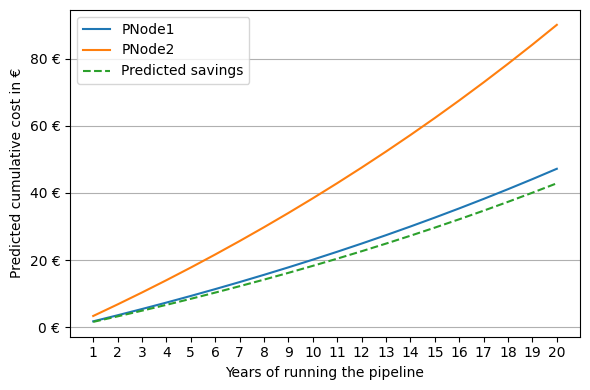

In [23]:
import matplotlib.ticker as mticker

plt.figure(figsize=(6, 4))
sns.lineplot(x=list(range(1, len(total_cost_per_year_pnode1)+1)), y=total_cost_per_year_pnode1,
             palette='deep', label='PNode1')
sns.lineplot(x=list(range(1, len(total_cost_per_year_pnode2)+1)), y=total_cost_per_year_pnode2,
             palette='deep', label='PNode2')
sns.lineplot(x=list(range(1, len(savings_per_year)+1)), y=savings_per_year,
             palette='deep', label='Predicted savings', linestyle='dashed')
plt.xlabel('Years of running the pipeline')
plt.ylabel('Predicted cumulative cost in €')

plt.gca().yaxis.grid(True)
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.gca().yaxis.set_major_formatter('{x:1.0f} €')
plt.tight_layout()

plt.savefig('predicted-cost.pdf', dpi=300)
plt.show()

Pearson Correlation tests

In [24]:
from scipy.stats import pearsonr

for name, group in node12.groupby('source'):
      print(name, pearsonr(group['pipeline_duration'],
            group['pipeline_joules_consumption']))
      print(name, pearsonr(group['pipeline_duration'],
            group['pipeline_avg_watts_consumption']))
      print(name, pearsonr(group['concurrency_degree'],
            group['pipeline_joules_consumption']))
      print(name, pearsonr(group['concurrency_degree'],
            group['pipeline_avg_watts_consumption']))
      print(name, pearsonr(group['concurrency_degree'],
            group['pipeline_duration']))
      print()

PNode1 PearsonRResult(statistic=0.9442709421937558, pvalue=2.1382751035254896e-144)
PNode1 PearsonRResult(statistic=-0.9791278225345448, pvalue=3.482531475909109e-206)
PNode1 PearsonRResult(statistic=-0.9330678598962814, pvalue=5.0014731340538645e-133)
PNode1 PearsonRResult(statistic=0.9463881122215523, pvalue=8.275165061895786e-147)
PNode1 PearsonRResult(statistic=-0.8918514705155591, pvalue=1.188152890861626e-103)

PNode2 PearsonRResult(statistic=0.9935978651908901, pvalue=5.977847880111727e-272)
PNode2 PearsonRResult(statistic=-0.9655630719571954, pvalue=1.0892283329761878e-168)
PNode2 PearsonRResult(statistic=-0.9023904785057573, pvalue=3.3207488401420164e-106)
PNode2 PearsonRResult(statistic=0.9625911344995144, pvalue=1.1686857660654436e-163)
PNode2 PearsonRResult(statistic=-0.8944785760502155, pvalue=1.2317231851889228e-101)



T-Test to check if there is a significant difference between both nodes in terms of consumption

In [25]:
from scipy import stats

for i in range(1, 7):
    if i != 3: # because 3 is non-normal for PNode2
        _, p_value = stats.ttest_ind(
            node1[node1['concurrency_degree'] == i]['pipeline_joules_consumption'], node2[node2['concurrency_degree'] == i]['pipeline_joules_consumption'])

        # Interpret the results:
        alpha = 0.05
        if p_value < alpha:
            print(f"Concurrency={i}",
                "Reject the null hypothesis,", f"p-value={p_value}")
        else:
            print(f"Concurrency={i}", "Fail to reject the null hypothesis,", f"p-value={p_value}")

Concurrency=1 Reject the null hypothesis, p-value=2.594787160326359e-138
Concurrency=2 Reject the null hypothesis, p-value=6.681563168504972e-145
Concurrency=4 Reject the null hypothesis, p-value=2.6176304677659385e-141
Concurrency=5 Reject the null hypothesis, p-value=1.0488048607713682e-136
Concurrency=6 Reject the null hypothesis, p-value=6.883292855539613e-141


Mann-Whitney-U-Test, for non-normal distributions & to reinforce findings

In [26]:
import scipy.stats as stats

for i in range(1, 7):
    _, p_value = stats.mannwhitneyu(node1[node1['concurrency_degree'] == i]['pipeline_joules_consumption'],
                       node2[node2['concurrency_degree'] == i]['pipeline_joules_consumption'], alternative='two-sided')
    
    # Interpret the results:
    alpha = 0.05
    if p_value < alpha:
        print(f"Concurrency={i}",
            "Reject the null hypothesis,", f"p-value={p_value}")
    else:
        print(f"Concurrency={i}", "Fail to reject the null hypothesis,", f"p-value={p_value}")

Concurrency=1 Reject the null hypothesis, p-value=2.40491154385185e-16
Concurrency=2 Reject the null hypothesis, p-value=1.037416185127664e-17
Concurrency=3 Reject the null hypothesis, p-value=7.380866101012222e-17
Concurrency=4 Reject the null hypothesis, p-value=7.066071930388932e-18
Concurrency=5 Reject the null hypothesis, p-value=7.066071930388932e-18
Concurrency=6 Reject the null hypothesis, p-value=7.066071930388932e-18
